# Data analysis from *Dopamine and serotonin interplay for valence-based spatial learning* by Wert-Carvajal _et al.,_ (2022)

For any questions about the code please contact [Carlos Wert-Carvajal](mailto:carloswertcarvajal@gmail.com)

Import packages to retrieve data and analyze it:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import fnmatch
import pickle
from scipy.special import kl_div
from itertools import takewhile
import re
import matplotlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import ttest_ind
import pandas as pd

## Formatting options 
Modify and run this cell to get the styling options of the article

In [2]:
#Styling options

hfont = {'family':'Helvetica','size':15}
matplotlib.rc('font', **hfont)

from cycler import cycler
import matplotlib.colors as mcolors
from matplotlib import cm

#Colors from paper in the order of Figure 2

col_purple=[173/256,147/256,178/256]
col_orange=[246/256,197/256,128/256]
col_green=[62/256,131/256,115/256]
col_red=[255/256,131/256,115/256]
col_blue=[164/256,209/256,239/256]
col_grey=[204/256,204/256,204/256]
vals = np.ones((6, 4))

vals[:, 0] = [col_green[0],col_blue[0],col_red[0],col_orange[0],
              col_purple[0],col_grey[0]]
vals[:, 1] = [col_green[1],col_blue[1],col_red[1],col_orange[1],
              col_purple[1],col_grey[1]]
vals[:, 2] = [col_green[2],col_blue[2],col_red[2],col_orange[2],
              col_purple[2],col_grey[2]]

cmap = mcolors.ListedColormap(vals)

from matplotlib.markers import TICKDOWN

# Modified viridis for heatmaps
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))[:,0:4]
newcolors[:,1]=0.85*newcolors[:,1]+0.1
newcolors[:,2]=0.7*newcolors[:,2]+0.3
newcolors[:,3]=0.4*newcolors[:,3]+0.6
newcmp = ListedColormap(newcolors)

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=cmap.colors)
plt.close('all')

matplotlib.cm.register_cmap("mycolormap", cmap)

# Function to plot significance in bar plots

def significance_bar(ax,start,end,height,displaystring,linewidth = 1.2,markersize = 5,boxpad  =0.1,fontsize = 11,color = 'k'):
    # draw a line with downticks at the ends
    ax.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    ax.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

## Useful statistical and analytical functions
Run the following cells to get the KL-divergence and pass from the cumulative reward array to a count by episode

In [3]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

def simulations_count(mat):
    individual = np.zeros_like(mat)
    for m in range(mat.shape[0]):
        for n in range(mat.shape[1]):
            if n==0:
                individual[m,n]=mat[m,n]
            elif n>0:
                individual[m,n]=mat[m,n]-mat[m,n-1]
    return individual

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

## Figure 2

This code gets files required for plotting and recreating Figure 2. 

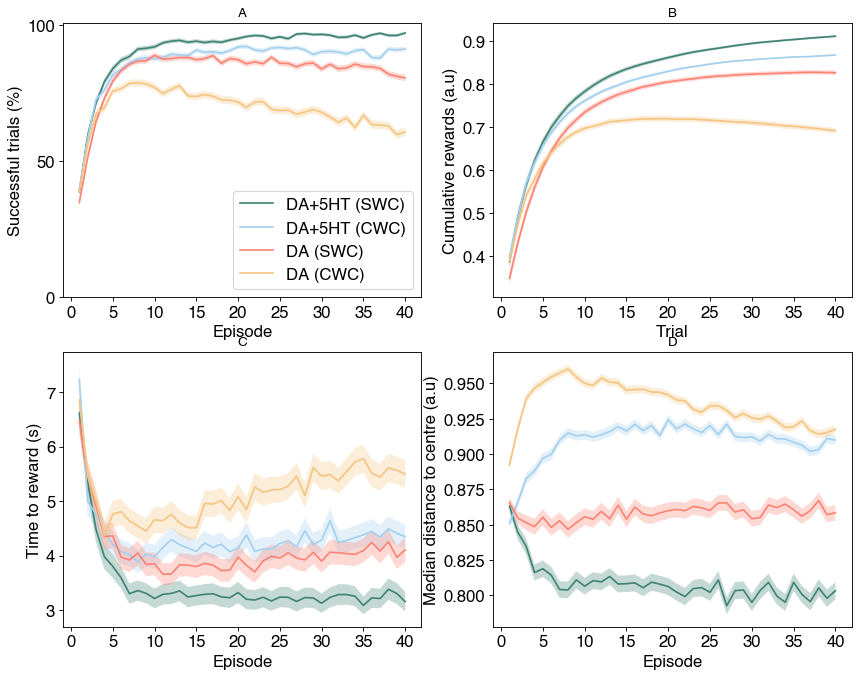

In [4]:
# Import data
dire = './Data_Analysis/Figure2/'
trial_time = 40 #Number of episodes
fig2, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12.72,10),dpi=80,facecolor='w',edgecolor='k')

#Run for files
for file in sorted(os.listdir(dire)):
    filename=os.path.join(dire,file)
    if fnmatch.fnmatch(file,'*.pickle'):
        with open(filename,'rb') as file:
            description,series = pickle.load(file)
            episode,first_reward,sucess_trials,punishing_trials,quadrant_map,median_distance,time_reward,time_reward2,time_reward_old, avg_weight,*___ = [list(i) for i in zip(*series)]
        t=np.linspace(1,trial_time,trial_time)
        total_episodes=description['episodes'] #NOTE EPISODES ARE TRIALS HERE
        
        #Subfigure A
        s_line=np.mean(simulations_count(np.array(sucess_trials)*100),axis=0)[0:trial_time]
        s_sem=(np.std(simulations_count(np.array(sucess_trials)*100),axis=0)/np.sqrt(total_episodes))[0:trial_time]
        plot_col, = ax1.plot(t[0:trial_time],s_line)
        ax1.fill_between(t[0:trial_time], s_line+s_sem,s_line-s_sem,alpha=0.3)
        ax1.set_xlabel('Episode')
        ax1.set_yticks([0,50,100])
        ax1.set_ylabel('Successful trials (%)')
        ax1.set_xticks([0,5,10,15,20,25,30,35,40])
        ax1.set_title('A',size=12)
        
        #Subfigure B
        s_line=np.mean(np.array(sucess_trials)/t,axis=0)[0:trial_time]
        s_sem=(np.std(np.array(sucess_trials)/t,axis=0)/np.sqrt(total_episodes))[0:trial_time]
        ax2.plot(t[0:trial_time],s_line)
        ax2.fill_between(t[0:trial_time], s_line+s_sem,s_line-s_sem,alpha=0.3)
        ax2.set_xlabel('Trial')
        ax2.set_ylabel('Cumulative rewards (a.u)')
        ax2.set_xticks([0,5,10,15,20,25,30,35,40])
        ax2.set_title('B',size=12)
        
        #Subfigure C
        time_reward=np.squeeze(np.dstack(time_reward)/1000)
        s_line=((np.nanmean(np.where(time_reward!=0,time_reward,np.nan),1)))[0:trial_time]
        s_err=1.96*(np.nanstd(np.where(time_reward!=0,time_reward,np.nan),1)/np.sqrt(total_episodes))[0:trial_time]
        ax3.plot(t[0:trial_time],s_line)
        ax3.fill_between(t[0:trial_time], np.squeeze(s_line+s_err),np.squeeze(s_line-s_err),alpha=0.3)
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Time to reward (s)')
        ax3.set_xticks([0,5,10,15,20,25,30,35,40])
        ax3.set_title('C',size=12)
        
        #Subfigure D
        median_distance2=np.squeeze(np.dstack(median_distance))
        s_line=(np.nanmean(np.where(median_distance2!=0,median_distance2,np.nan),1))
        s_sem=(np.nanstd(np.where(median_distance2!=0,median_distance2,np.nan),1)[0:trial_time]/np.sqrt(total_episodes))
        ax4.plot(t,s_line)
        ax4.fill_between(t, np.squeeze(s_line+s_sem),np.squeeze(s_line-s_sem),alpha=0.3)
        ax4.set_xlabel('Episode')
        ax4.set_xticks([0,5,10,15,20,25,30,35,40])
        ax4.set_ylabel('Median distance to centre (a.u)')
        ax4.set_title('D',size=12)

ax1.legend(['DA+5HT (SWC)','DA+5HT (CWC)','DA (SWC)','DA (CWC)'])

## Figure 3

The data is contained and analysis first with CWC and then SWC. The histogram plots are plotted separately.


CWC p-values Plat inh: 0.0 No plat inhib 0.0 Platact: 0.0 NoPlat act: 0.0
SWC p-values Plat inh: 0.0 No plat inhib 0.0 Platact: 0.0 NoPlat act: 0.0


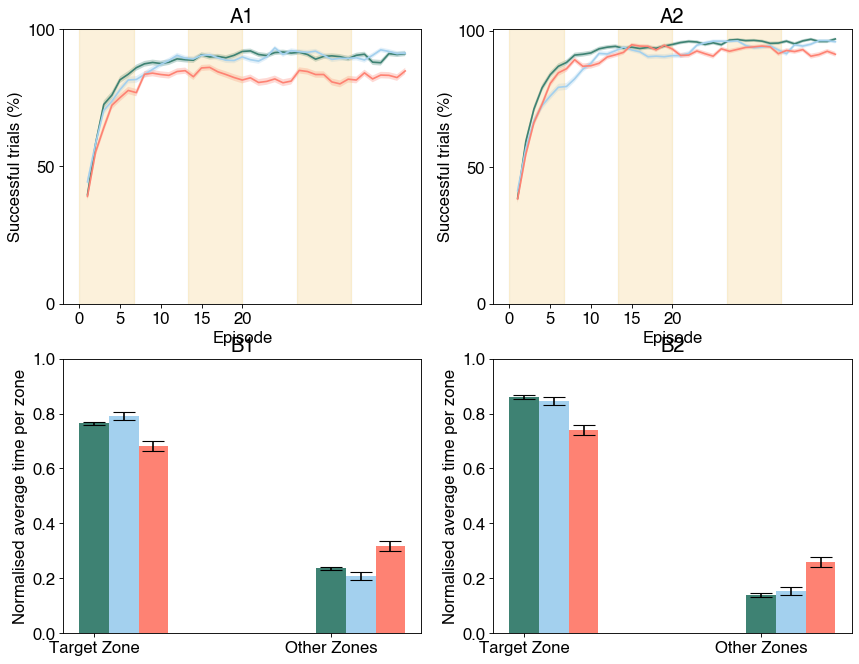

In [5]:
type_set = ['CWC','SWC']
trial_time = 40 #Number of episodes
fig3, (axa,axb) = plt.subplots(2,2,figsize=(12.72,10),dpi=80,facecolor='w',edgecolor='k')

#Run for files
for ityp, type_rule in enumerate(type_set):
    dire = os.path.join('./Data_Analysis/Figure3/',type_rule)
    for its,file in enumerate(sorted(os.listdir(dire))):
        filename=os.path.join(dire,file)
        legends = []
        if fnmatch.fnmatch(file,'*.pickle'):
            with open(filename,'rb') as file:
                description,series = pickle.load(file)
                episode,first_reward,sucess_trials,punishing_trials,quadrants,median_distance,time_reward,time_reward2,time_reward_old, avg_weight,*___ = [list(i) for i in zip(*series)]

            # Plot A
            t=np.linspace(1,trial_time,trial_time)
            total_episodes=description['episodes'] #NOTE EPISODES ARE TRIALS HERE
            legends.append(''+("Activated")*description['Activ']+("Inhibited")*description['Inhib']+("Normal")*(not description['Inhib'])*(not description['Activ']))
            s_line=np.mean(simulations_count(np.array(sucess_trials)*100),axis=0)[0:trial_time]
            s_sd=(np.std(simulations_count(np.array(sucess_trials)*100),axis=0)/np.sqrt(total_episodes))[0:trial_time]
            plot_col, = axa[ityp].plot(t[0:trial_time],s_line)
            axa[ityp].fill_between(t[0:trial_time], s_line+s_sd,s_line-s_sd,alpha=0.3)
            axa[ityp].set_xlabel('Episode')
            axa[ityp].axvspan(0, 40/6, alpha=0.1, color=[250/256,211/256,132/256])
            axa[ityp].axvspan(80/6, 120/6, alpha=0.1, color=[250/256,211/256,132/256])
            axa[ityp].axvspan(160/6, 200/6, alpha=0.1, color=[250/256,211/256,132/256])
            axa[ityp].set_yticks([0,50,100])
            axa[ityp].set_ylabel('Successful trials (%)')
            axa[ityp].set_xticks([0,5,10,15,20])
            axa[ityp].set_title('A'+str(ityp+1))
            
            # Plot B
            if its==1:
                #Normal sample has the incorrect quadrant position
                plat=np.mean(np.array(quadrants)[:,39,2])
                no_plat=np.mean(np.sum(np.array(quadrants)[:,39,(0,1,3)],axis=1))
            else:
                plat=np.mean(np.array(quadrants)[:,39,1])
                no_plat=np.mean(np.sum(np.array(quadrants)[:,39,(0,2,3)],axis=1))

            plat_sd=1.96*np.std(np.array(quadrants)[:,39,1])/np.sqrt(total_episodes)
            no_plat_sd=1.96*np.std(np.sum(np.array(quadrants)[:,39,(0,2,3)],axis=1))/np.sqrt(total_episodes)
            axb[ityp].bar(np.arange(2)+0.125*its,[plat,no_plat],0.125,yerr=[plat_sd,no_plat_sd],capsize=10)
            axb[ityp].set_title('B'+str(ityp+1))
            axb[ityp].set_ylabel('Normalised average time per zone')
            axb[ityp].set_yticks(np.linspace(0,1,6))
            axb[ityp].set_xticks(np.arange(2)+0.25 / 2)
            axb[ityp].set_xticklabels(('Target Zone','Other Zones'))
            if description['Inhib']:
                plat1 =np.array(quadrants)[:,39,1]
                noplat1=np.sum(np.array(quadrants)[:,39,(0,2,3)],axis=1)
            elif description['Activ']:
                plat3  =np.array(quadrants)[:,39,1]
                noplat3=np.sum(np.array(quadrants)[:,39,(0,2,3)],axis=1)
            else:
                plat2  =np.array(quadrants)[:,39,1]
                noplat2=np.sum(np.array(quadrants)[:,39,(0,2,3)],axis=1)

    t1,p1=ttest_ind(plat1,plat2)
    t2,p2=ttest_ind(noplat1,noplat2)
    t1,p3=ttest_ind(plat2,plat3)
    t1,p4=ttest_ind(noplat2,noplat3)
    print(type_rule+' p-values Plat inh:',p1,'No plat inhib',p2,'Platact:',p3,'NoPlat act:',p4)

## Figure 4

The data is contained and analysis first with CWC and then SWC. The histogram plots are plotted separately.

Text(0, 0.5, 'Learning rate')

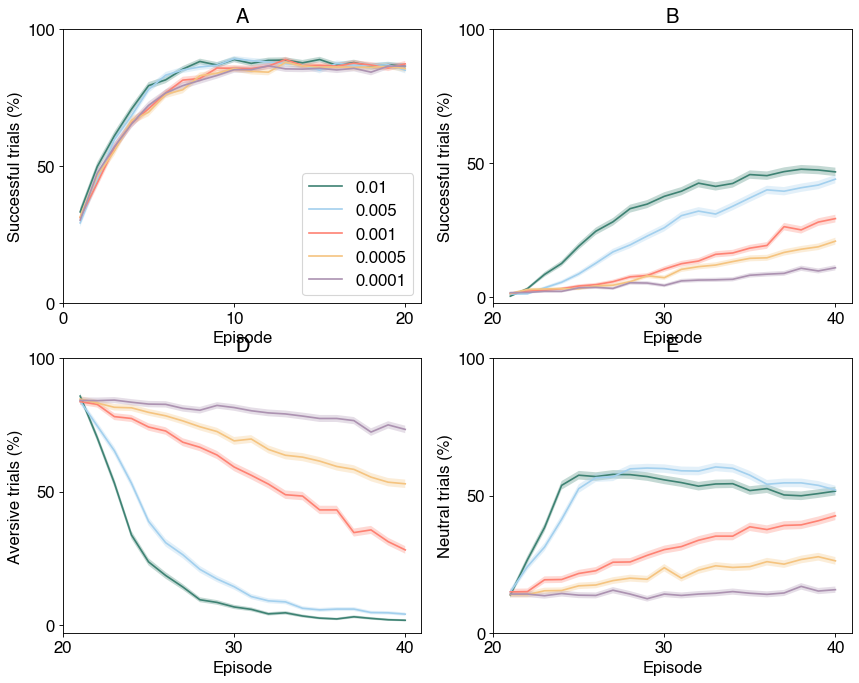

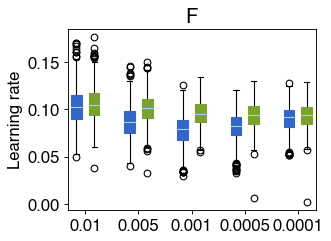

In [6]:
from scipy.stats import variation

dire = './Data_Analysis/Figure4/'
trial_time = 40 #Number of episodes
fig4, ((axa,axb),(axd,axe)) = plt.subplots(2,2,figsize=(12.72,10),dpi=80,facecolor='w',edgecolor='k')

fig4f, (axf) = plt.subplots(1,1,figsize=(4,3),dpi=80,facecolor='w',edgecolor='k')

#Run for files
legends = []
countc = 0
for its,file in enumerate(sorted(os.listdir(dire))):
    filename=os.path.join(dire,file)
    if fnmatch.fnmatch(file,'*.pickle'):
        with open(filename,'rb') as file:
            description,series = pickle.load(file)
            episode,first_reward,sucess_trials,punishing_trials,quadrant_map,median_distance,time_reward,time_reward_neg,w_tot_old,avg_weight,w_tot_old,w_tot_old_2 = [list(i) for i in zip(*series)]
        t=np.linspace(1,trial_time,trial_time)
        legends+=[description['eta_Sero']]
        
        # Plot A
        total_episodes=description['episodes'] #NOTE EPISODES ARE TRIALS HERE
        s_line=np.mean(simulations_count(np.array(sucess_trials)*100),axis=0)[0:20]
        s_sd=(np.std(simulations_count(np.array(sucess_trials)*100),axis=0)/np.sqrt(total_episodes))[0:20]
        plot_col, = axa.plot(t[:20],s_line)
        axa.fill_between(t[:20], s_line+s_sd,s_line-s_sd,alpha=0.3)
        axa.set_xlabel('Episode')
        axa.set_yticks([0,50,100])
        axa.set_ylabel('Successful trials (%)')
        axa.set_xticks([0,10,20])
        axa.set_title('A')
        
        # Plot B
        total_episodes=description['episodes'] #NOTE EPISODES ARE TRIALS HERE
        s_line=np.mean(simulations_count(np.array(sucess_trials)*100),axis=0)[20:40]
        s_sd=(np.std(simulations_count(np.array(sucess_trials)*100),axis=0)/np.sqrt(total_episodes))[20:40]
        plot_col, = axb.plot(t[20:40],s_line)
        axb.fill_between(t[20:40], s_line+s_sd,s_line-s_sd,alpha=0.3)
        axb.set_xlabel('Episode')
        axb.set_yticks([0,50,100])
        axb.set_ylabel('Successful trials (%)')
        axb.set_xticks([20,30,40])
        axb.set_title('B')
        
        # Plot D
        total_episodes=description['episodes'] #NOTE EPISODES ARE TRIALS HERE
        s_line=np.mean(simulations_count(np.array(punishing_trials)*100),axis=0)[20:40]
        s_sd=(np.std(simulations_count(np.array(punishing_trials)*100),axis=0)/np.sqrt(total_episodes))[20:40]
        plot_col, = axd.plot(t[20:40],s_line)
        axd.fill_between(t[20:40], s_line+s_sd,s_line-s_sd,alpha=0.3)
        axd.set_xlabel('Episode')
        axd.set_yticks([0,50,100])
        axd.set_ylabel('Aversive trials (%)')
        axd.set_xticks([20,30,40])
        axd.set_title('D')
        
        # Plot E
        neutral = -simulations_count(np.array(sucess_trials))-simulations_count(np.array(punishing_trials))+1
        total_episodes=description['episodes'] #NOTE EPISODES ARE TRIALS HERE
        s_line=np.mean(neutral*100,axis=0)[20:40]
        s_sd=(np.std(neutral*100,axis=0)/np.sqrt(total_episodes))[20:40]
        plot_col, = axe.plot(t[20:40],s_line)
        axe.fill_between(t[20:40], s_line+s_sd,s_line-s_sd,alpha=0.3)
        axe.set_xlabel('Episode')
        axe.set_yticks([0,50,100])
        axe.set_ylabel('Neutral trials (%)')
        axe.set_xticks([20,30,40])
        axe.set_title('E')
        
        # Plot F
        w_tot=variation(np.mean(np.array(w_tot_old),axis=1), axis=1)
        w_tot_2=variation(np.mean(np.array(w_tot_old_2),axis=1), axis=1)
        positions = [1+countc*3, 2+countc*3]
        countc+=1
        bp=axf.boxplot([w_tot_2,w_tot],positions = positions,patch_artist=True,widths = 0.6)
        plt.setp(bp["boxes"][0], color=[51/256,102/256,199/256])
        plt.setp(bp["boxes"][1], color=[123/256,162/256,48/256])
axf.set_xticks([1.5, 4.5, 7.5,10.5,13.5])
axa.legend(legends)
axf.set_xticklabels(legends)
axf.set_title('F')
axf.set_ylabel('Coefficient of variation (a.u)')
axf.set_ylabel('Learning rate')